# 07. Hypothesis and Conclusion

## Imports

In [39]:
import math
import random

import plotly.graph_objects as go

In [2]:
# Importing functions from another notebook with supress graph rendering

_print = print
globals()["print"] = lambda *args, **kwargs: None

_show = go.Figure.show
go.Figure.show = lambda *args, **kwargs: None

%run -i ../06_probability/main.ipynb

globals()["print"] = _print
go.Figure.show = _show

## Coin Tossing

<b>Hypothesis 0</b>: coin is balanced, so p_heads = p_tails = 0.5.

In [3]:
# Approximation of a binomial random variable by a normal distribution


def normal_approximation_to_binomial(n: int, p: float) -> tuple[float, float]:
    mu = p * n
    sigma = math.sqrt(p * (1 - p) * n)
    return mu, sigma

In [5]:
# normal_cdf: variable probability lies below threshold

normal_probability_below = normal_cdf

In [6]:
# Variable lies above threshold, if it is not below threshold


def normal_probability_above(lo: float, mu: float = 0, sigma: float = 1) -> float:
    return 1 - normal_cdf(lo, mu, sigma)

In [7]:
# Variable lies between if it is less than hi, but not less than lo


def normal_probability_between(
    lo: float, hi: float, mu: float = 0, sigma: float = 1
) -> float:
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

In [8]:
# Variable lies outside if it does not lie between


def normal_probability_outside(
    lo: float, hi: float, mu: float = 0, sigma: float = 1
) -> float:
    return 1 - normal_probability_between(lo, hi, mu, sigma)

In [9]:
# Upper bound search function


def normal_upper_bound(probability: float, mu: float = 0, sigma: float = 1) -> float:
    return inverse_normal_cdf(probability, mu, sigma)

In [10]:
# Lower bound search function


def normal_lower_bound(probability: float, mu: float = 0, sigma: float = 1) -> float:
    return inverse_normal_cdf(1 - probability, mu, sigma)

In [30]:
# Two bounds search function


def normal_two_sided_bounds(
    probability: float, mu: float = 0, sigma: float = 1
) -> tuple[float, float]:
    tail_probability = (1 - probability) / 2

    upper_bound = normal_lower_bound(tail_probability, mu, sigma)
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)

    return lower_bound, upper_bound

We decided to make 1000 throws.

If the hypothesis of the coin's equilibrium is true,<br>
then $X$ should be approximately normally distributed with<br>
an average value of 500 and a standard deviation of 15.8.

In [ ]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)

We need to make a decision about significance, that is,<br>
how ready we are to make a mistake of the first kind ("false statement"),<br>
in which we reject $H_0$, even if it is true. This readiness is set at 5%.

In [ ]:
# Consider a check that rejects H_0 if X falls outside the bounds set as follows:

lower_bound, upper_bound = normal_two_sided_bounds(0.95, mu_0, sigma_0)

Assuming that $p$ is indeed 0.5 (that is, the hypothesis is true),<br>
there is only a 5% chance that we observe<br>
a random variable $X$ that lies outside this interval.

In addition to the above, we are interested in the verification power,<br>
that is, the probability of not making a second-kind error ("false negation")<br>
when we fail to reject $H_0$, even if it is false.

In [ ]:
# 95% of the boundary based on the assumption that p=0.5

lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)

In [ ]:
# Actual mu and sigma based on p=0.55

mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)

In [ ]:
# The second kind of error means that we failed to reject the null hypothesis,
# which will happen when X is still inside our initial interval

type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)

print(f"[+] Power: {1 - type_2_probability:.4f}")

Let's assume that our null hypothesis was that<br>
the coin is not biased towards the eagles or that $p \le 0.5$.<br>
In this case, we need a one-way check that rejects<br>
the null hypothesis when $X > 500$ and does not reject when $X < 500$.

In [32]:
hi = normal_upper_bound(0.95, mu_0, sigma_0)

type_2_probability = normal_probability_below(hi, mu_1, sigma_1)

print(f"[+] Power: {1 - type_2_probability:.4f}")

[+] Power: 0.8865


## P-values

An alternative approach to the above verification involves applying a $p$-$value$.<br>
Instead of choosing boundaries based on some probability cut-off point,<br>
the probability of obtaining (at least)<br>
the same limit value as what was actually observed is calculated.

In [34]:
# Two-way p-value


def two_sided_p_value(x: float, mu: float = 0, sigma: float = 1) -> float:
    if x >= mu:
        return 2 * normal_probability_above(x, mu, sigma)
    else:
        return 2 * normal_probability_below(x, mu, sigma)


# P-value when 530 eagles appear on a coin
two_sided_p_value(529.5, mu_0, sigma_0)

In [40]:
# Simulation of the loss of 530 eagles on a coin

extreme_value_count = 0

for _ in range(1000):
    num_heads = sum(1 if random.random() < 0.5 else 0 for _ in range(1000))
    if num_heads >= 530 or num_heads <= 470:
        extreme_value_count += 1

assert 59 < extreme_value_count < 65, f"{extreme_value_count}"

AssertionError: 67

Since the $p$-$value$ exceeds the specified 5% significance level,<br>
the null hypothesis is not rejected.

In [41]:
# P-value when 532 eagles appear on a coin

two_sided_p_value(531.5, mu_0, sigma_0)

0.046345287837786575

In [42]:
# The upper and lower p-values can be obtained in a similar way

upper_p_value = normal_probability_above
lower_p_value = normal_probability_below

In [43]:
# One-way check for the loss of 525 eagles on a coin

upper_p_value(524.5, mu_0, sigma_0)

0.06062885772582072

Since the $p$-$value$ is greater than 0.5: the hypothesis will not be rejected.

In [45]:
# One-way check for the loss of 527 eagles on a coin

upper_p_value(526.5, mu_0, sigma_0)

0.04686839508859242

Since the $p$-$value$ is less than 0.5: the hypothesis will be rejected.

## Confidence Intervals

We tested hypotheses about the value of the probability of eagles $p$,<br>
that is, the parameter of the unknown distribution of "eagles".<br>
In this case, a third approach is used:<br>
a confidence interval is built around the observed parameter value.

If there were a $p$-$value$, then according to the central limit theorem,<br>
the average of these Bernoulli quantities should be<br>
approximately normal with an average $p$ and a standard deviation:

In [ ]:
# math.sqrt(p * (1 - p) / 1000)

In [46]:
# Since the p-value is unknown, we use an approximate estimate

p_hat = 525 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000)

sigma

0.015791611697353755

In [47]:
normal_two_sided_bounds(0.95, mu, sigma)

(0.4940490278129096, 0.5559509721870904)

Accordingly, with 95% confidence, this interval contains the true value of $p$.

In [49]:
# If there were 540 eagles on the coin

p_hat = 540 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) / 1000)

sigma

0.015760710643876435

In [50]:
normal_two_sided_bounds(0.95, mu, sigma)

(0.5091095927295919, 0.5708904072704082)

The "balanced coin" does not lie in the confidence interval.

## Hacking P-value

Below is a procedure that rejects the null hypothesis only in 5% of cases<br>
(by definition, in 5% of cases it will reject the null hypothesis by mistake).

In [51]:
def run_experiment() -> list[bool]:
    return [random.random() < 0.5 for _ in range(1000)]

In [52]:
def reject_fairness(experiment: list[bool]) -> bool:
    num_heads = len([flip for flip in experiment if flip])
    return num_heads < 469 or num_heads > 531

In [55]:
random.seed(0)
experiments = [run_experiment() for _ in range(1000)]
num_rejections = len(
    [experiment for experiment in experiments if reject_fairness(experiment)]
)

assert num_rejections == 46

This means that if you set out to find "meaningful" results, then you can definitely find them.

## A/B Testing

In [56]:
def estimated_parameters(N: int, n: int) -> tuple[float, float]:
    p = n / N
    sigma = math.sqrt(p * (1 - p) / N)
    return p, sigma

If we assume that two normal random variables are mutually independent,<br>
then their difference should also be normal<br>
with an average value $p_B - p_A$ and a standard deviation $\sqrt{\sigma_A^2 - \sigma_B^2}$.

In [57]:
def a_b_test_statistic(N_A: int, n_A: int, N_B: int, n_B: int) -> float:
    p_A, sigma_A = estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    return (p_B - p_A) / math.sqrt(sigma_A**2 + sigma_B**2)

In [58]:
z = a_b_test_statistic(1000, 200, 1000, 180)

z

-1.1403464899034472

In [59]:
# The probability of getting a large difference between the two values.

two_sided_p_value(z)

0.2541419765422359

In [60]:
z = a_b_test_statistic(1000, 200, 1000, 150)

z

-2.948839123097944

In [61]:
# The probability of getting a large difference between the two values.

two_sided_p_value(z)

0.003189699706216853

## Bayesian Inference

The procedures discussed above provided for the nomination of probabilistic<br>
statements regarding the verification of statistical hypotheses such as<br>
"if the null hypothesis is true, then the chance of detecting such and such marginal statistics is 3%".

An alternative approach to statistical inference involves treating<br>
the unknown parameters themselves as random variables.<br>
It is required to start with an a priori distribution for the parameters and<br>
then use the observed data and Bayes' theorem to obtain an updated a posteriori distribution.<br>
Instead of probabilistic judgments about the checks,<br>
probabilistic judgments are made about the parameters themselves.

For example, if the unknown parameter is probability,<br>
then often the a priori probability distribution is takenfrom the beta distribution,<br>
which places its entire probability between 0 and 1.

In [62]:
def B(alpha: float, beta: float) -> float:
    return math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)

In [63]:
def beta_pdf(x: float, alpha: float, beta: float) -> float:
    if x <= 0 or x >= 1:
        return 0
    return x ** (alpha - 1) * (1 - x) ** (beta - 1) / B(alpha, beta)

In [74]:
xs = [x / 100.0 for x in range(-100, 100)]

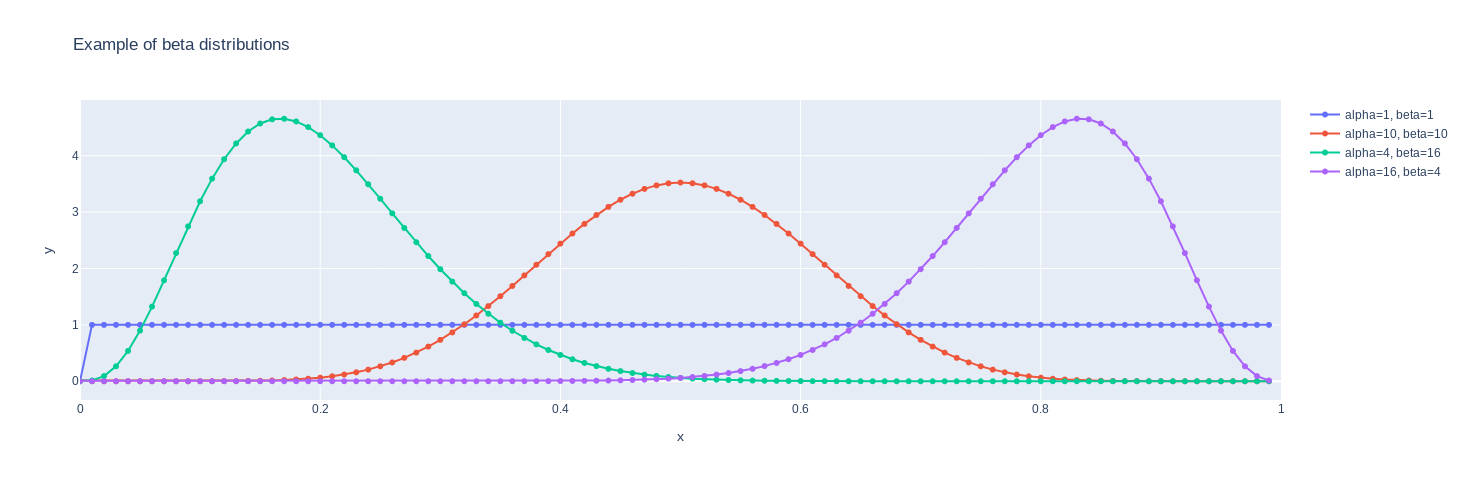

In [85]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=xs,
        y=[beta_pdf(x, 1, 1) for x in xs],
        mode="lines+markers",
        name="alpha=1, beta=1",
    )
)
fig.add_trace(
    go.Scatter(
        x=xs,
        y=[beta_pdf(x, 10, 10) for x in xs],
        mode="lines+markers",
        name="alpha=10, beta=10",
    )
)
fig.add_trace(
    go.Scatter(
        x=xs,
        y=[beta_pdf(x, 4, 16) for x in xs],
        mode="lines+markers",
        name="alpha=4, beta=16",
    )
)
fig.add_trace(
    go.Scatter(
        x=xs,
        y=[beta_pdf(x, 16, 4) for x in xs],
        mode="lines+markers",
        name="alpha=16, beta=4",
    )
)

fig.update_xaxes(title_text="x", range=[0, 1])
fig.update_yaxes(title_text="y")

fig.update_layout(height=480, width=720, title_text="Example of beta distributions")

fig.show()

If alpha and beta are both equal to 1, then this is a uniform distribution.<br>
If alpha is much larger than beta, then most of the weight is around 1.<br>
If alpha is much smaller than beta, then most of the weight is around 0.

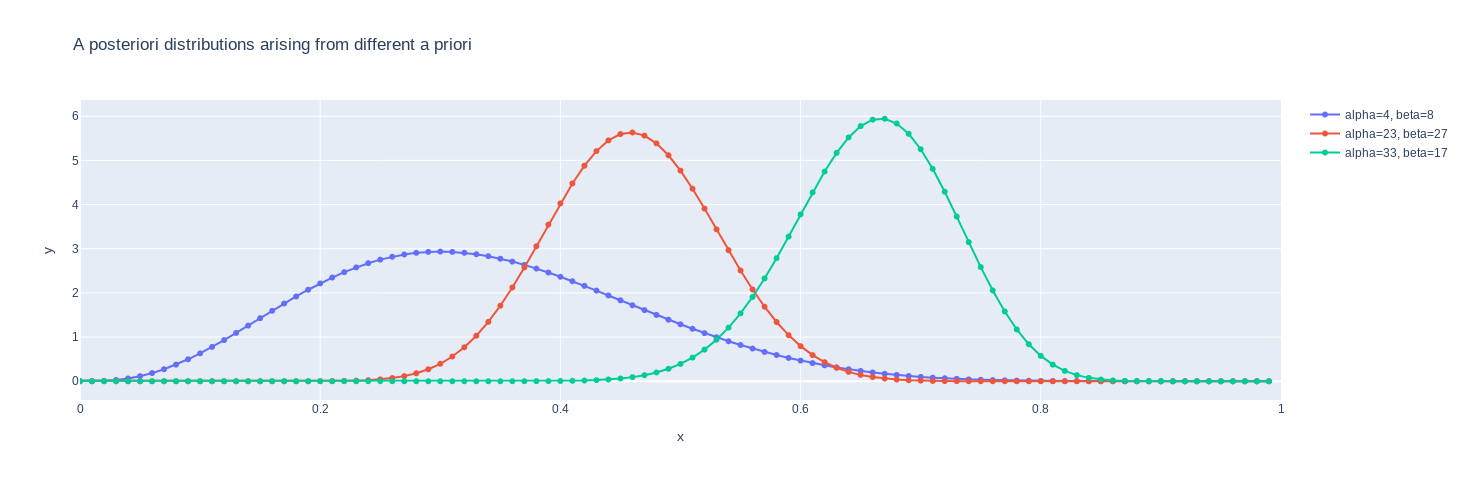

In [84]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=xs,
        y=[beta_pdf(x, 4, 8) for x in xs],
        mode="lines+markers",
        name="alpha=4, beta=8",
    )
)
fig.add_trace(
    go.Scatter(
        x=xs,
        y=[beta_pdf(x, 23, 27) for x in xs],
        mode="lines+markers",
        name="alpha=23, beta=27",
    )
)
fig.add_trace(
    go.Scatter(
        x=xs,
        y=[beta_pdf(x, 33, 17) for x in xs],
        mode="lines+markers",
        name="alpha=33, beta=17",
    )
)

fig.update_xaxes(title_text="x", range=[0, 1])
fig.update_yaxes(title_text="y")

fig.update_layout(
    height=480,
    width=720,
    title_text="A posteriori distributions arising from different a priori",
)

fig.show()